<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Modelo_XGBoost_con_series_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base de datos **(La Paz)**

In [1]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo, sep=';')  # Quien use este codigo asegúrate de usar el separador correcto

num_observaciones, num_variables = df.shape
print(f"Número de observaciones (filas): {num_observaciones}")
print(f"Número de variables (columnas): {num_variables}")

print("\n Lista de variables:")
print(df.columns.tolist())

Saving base_datos_solar_lapaz_2025 (1).csv to base_datos_solar_lapaz_2025 (1).csv
Número de observaciones (filas): 2880
Número de variables (columnas): 6

 Lista de variables:
['time', 'shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'energia_solar_kWh']



# Modelo XGBoost usando series de tiempo

**Objetivo del Proyecto**

Desarrollar un modelo de predicción para estimar la generación de energía solar en La Paz (Cesar), a partir de variables meteorológicas y temporales, mediante técnicas de aprendizaje automático con enfoque en series de tiempo.

### Cargar los datos, convertir la fecha y ordenarlos

Importamos los datos desde un archivo `.csv`, donde cada fila representaba una hora del día y contenía las condiciones meteorológicas en ese momento y cuánta energía solar se había generado.

In [2]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df.head()

,time,shortwave_radiation,temperature_2m,wind_speed_10m,relative_humidity_2m,energia_solar_kWh
0,2025-02-01 00:00:00,0.0,25.5,23.1,68,0.0
1,2025-02-01 01:00:00,0.0,25.0,21.8,69,0.0
2,2025-02-01 02:00:00,0.0,24.6,20.3,70,0.0
3,2025-02-01 03:00:00,0.0,24.3,19.7,72,0.0
4,2025-02-01 04:00:00,0.0,23.9,18.9,74,0.0


### Crear variables temporales y de retraso (lags)


| **Variable**           | **Significado**                                                                       |
| ---------------------- | ------------------------------------------------------------------------------------- |
| `temperature_2m`       | Temperatura del aire medida a 2 metros del suelo (°C). Afecta eficiencia de paneles.  |
| `wind_speed_10m`       | Velocidad del viento a 10 metros (m/s). Puede influir en refrigeración de paneles.    |
| `relative_humidity_2m` | Porcentaje de humedad del aire a 2 metros. Alta humedad suele implicar nubosidad.     |
| `hora`                 | Hora del día (0 a 23). Refleja el ciclo diario de generación solar.                   |
| `dia`                  | Día del mes. Útil para captar variaciones cortas.                                     |
| `mes`                  | Mes del año. Captura la estacionalidad anual.                                         |
| `dia_del_año`          | Día juliano (1–365). Mejora la captación de patrones anuales más finos.               |
| `dia_semana`           | Día de la semana (0=lunes, 6=domingo). Puede ser útil si hay diferencias semanales.   |
| `energia_lag_1`        | Energía solar generada **una hora antes**. Captura inercia inmediata en el sistema.   |
| `energia_lag_24`       | Energía solar generada **24 horas antes**. Ayuda a captar patrones diarios.           |
| `energia_roll_3`       | Promedio de energía en las **últimas 3 horas**. Suaviza y refleja tendencia reciente. |

In [3]:
import numpy as np

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(window=3).mean()

df = df.dropna()

df[['time', 'energia_solar_kWh', 'energia_lag_1', 'energia_lag_24', 'energia_roll_3']].head()


,time,energia_solar_kWh,energia_lag_1,energia_lag_24,energia_roll_3
24,2025-02-02 00:00:00,0.0,0.0,0.0,0.0
25,2025-02-02 01:00:00,0.0,0.0,0.0,0.0
26,2025-02-02 02:00:00,0.0,0.0,0.0,0.0
27,2025-02-02 03:00:00,0.0,0.0,0.0,0.0
28,2025-02-02 04:00:00,0.0,0.0,0.0,0.0


### Definir las variables predictoras `(X)` y la variable objetivo `(y)`, excluyendo shortwave_radiation

In [4]:
X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])

y = df['energia_solar_kWh']

print(" Variables predictoras (X):", list(X.columns))
print("\n Tamaño de X:", X.shape)
print(" Tamaño de y:", y.shape)

 Variables predictoras (X): ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'hora', 'dia', 'mes', 'dia_del_año', 'dia_semana', 'energia_lag_1', 'energia_lag_24', 'energia_roll_3']

 Tamaño de X: (2856, 11)
 Tamaño de y: (2856,)


### Separar los datos en entrenamiento y prueba (respetando el tiempo)

Como estamos trabajando con series de tiempo, no debemos mezclar datos del pasado y futuro de forma aleatoria. Por eso:

- Usaremos 80% de los datos más antiguos para entrenamiento

- Y el 20% más reciente para prueba

Esto imita cómo funcionaría el modelo en la vida real: entrena con el pasado y predice el futuro.

Usamos el 80% de los datos antiguos para entrenar el modelo (como si estuviéramos en el pasado), y el 20% más reciente para probarlo (como si predijéramos el futuro). Esto es muy importante en modelos con series de tiempo.

In [5]:
n = len(df)
n_train = int(n * 0.8)

X_train = X.iloc[:n_train]
X_test = X.iloc[n_train:]
y_train = y.iloc[:n_train]
y_test = y.iloc[n_train:]

print(f" Tamaño entrenamiento: {X_train.shape[0]} registros")
print(f" Tamaño prueba: {X_test.shape[0]} registros")


 Tamaño entrenamiento: 2284 registros
 Tamaño prueba: 572 registros


### Búsqueda de los mejores hiperparámetros

Vamos a usar `GridSearchCV` con validación cruzada para encontrar la mejor combinación de hiperparámetros para el modelo XGBoost.

Hasta encontrar la que da el menor error de predicción.

| Parámetro          | Qué controla                    | Valores a probar   |
| ------------------ | ------------------------------- | ------------------ |
| `n_estimators`     | Nº de árboles                   | \[100, 200]        |
| `max_depth`        | Profundidad máxima del árbol    | \[3, 5, 7]         |
| `learning_rate`    | Tasa de aprendizaje (step size) | \[0.01, 0.05, 0.1] |
| `subsample`        | % de datos usados por árbol     | \[0.8, 1.0]        |
| `colsample_bytree` | % de variables usadas por árbol | \[0.8, 1.0]        |


In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [7]:
print(" Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

 Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


### Entrenar el modelo XGBoost con los hiperparámetros óptimos

In [8]:
from xgboost import XGBRegressor

modelo_final = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

modelo_final.fit(X_train, y_train)

print(" Modelo entrenado con éxito.")

 Modelo entrenado con éxito.


### Evaluar el modelo

-  RMSE: error cuadrático medio raíz (error promedio en kWh).
- R² (R al cuadrado): qué tan bien explica el modelo la variabilidad.
- Gráfico de valores reales vs predichos: para ver si el modelo sigue bien la tendencia.

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = modelo_final.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" RMSE: {rmse:.4f}")
print(f" R²: {r2:.4f}")

 RMSE: 0.0127
 R²: 0.9757


In [10]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
print(f" MAE (XGBoost): {mae:.4f}")

import numpy as np

y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

mask = y_test_np != 0
y_test_filtered = y_test_np[mask]
y_pred_filtered = y_pred_np[mask]

mape_filtered = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered)

 MAE (XGBoost): 0.0065


In [11]:
mask = y_test_np > 0.25
y_test_filtered = y_test_np[mask]
y_pred_filtered = y_pred_np[mask]

if len(y_test_filtered) > 0:
    mape_filtrado = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered) * 100
    print(f" MAPE filtrado): {mape_filtrado:.2f}%")

 MAPE filtrado): 2.15%


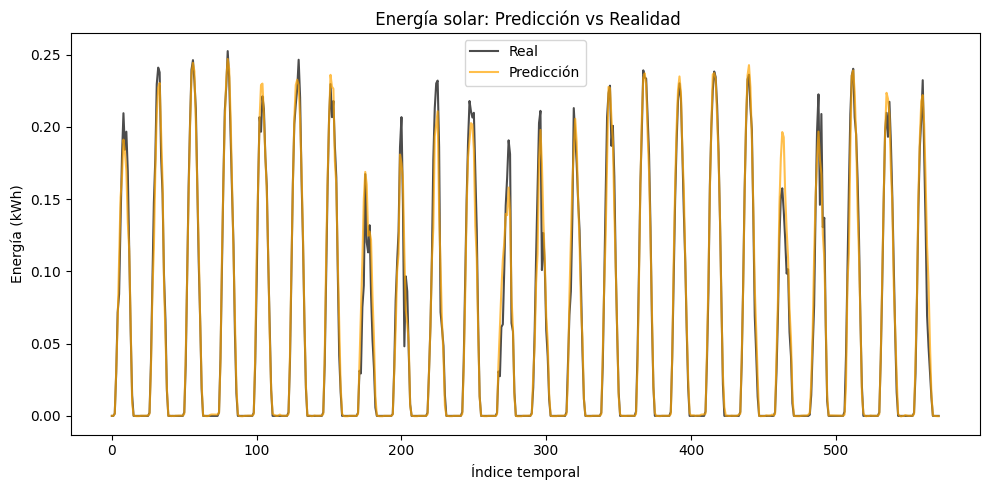

In [12]:
# Gráfico de comparación
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Real", color="black", alpha=0.7)
plt.plot(y_pred, label="Predicción", color="orange", alpha=0.7)
plt.title(" Energía solar: Predicción vs Realidad")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluar la importancia de las variables del modelo

Vamos a visualizar qué variables fueron más relevantes para el modelo XGBoost entrenado sin radiación solar, usando el atributo .feature_importances_.

/tmp/ipython-input-13-1132959553.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia, x='Importancia (%)', y='Variable', palette='viridis')


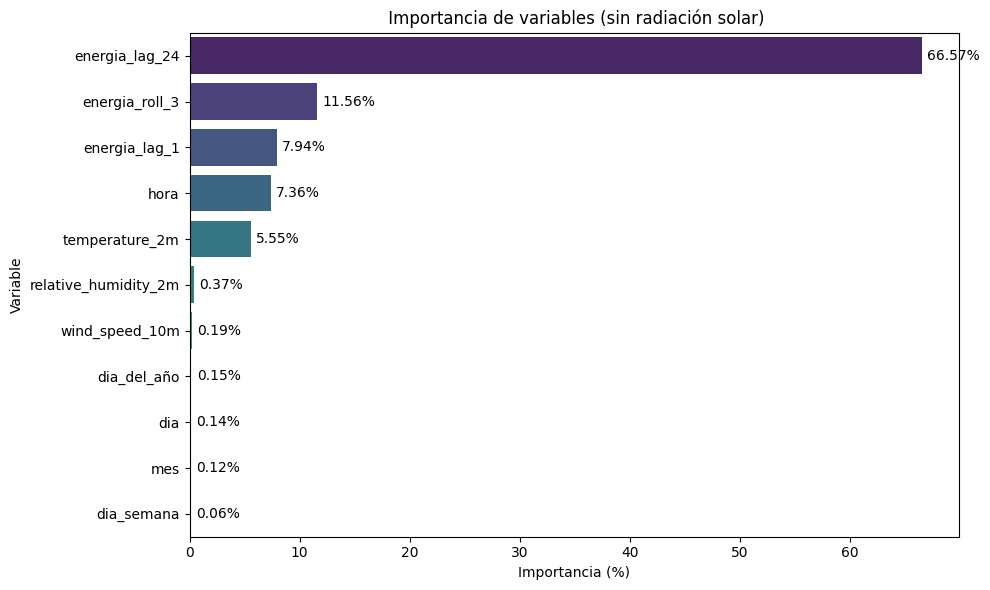

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importancias = modelo_final.feature_importances_
nombres = X_train.columns
porcentajes = 100 * (importancias / importancias.sum())

df_importancia = pd.DataFrame({
    'Variable': nombres,
    'Importancia (%)': porcentajes
}).sort_values(by='Importancia (%)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancia, x='Importancia (%)', y='Variable', palette='viridis')

for i, (valor, nombre) in enumerate(zip(df_importancia['Importancia (%)'], df_importancia['Variable'])):
    plt.text(valor + 0.5, i, f"{valor:.2f}%", va='center')

plt.title(" Importancia de variables (sin radiación solar)")
plt.xlabel("Importancia (%)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

| Variable                                 | Importancia (%) | ¿Qué significa esto?                                                                                                              |
| ---------------------------------------- | --------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **`energia_lag_24`**                     | **66.57%**      | La energía generada **24 horas antes** es el predictor más poderoso. El modelo aprendió que hay **patrones diarios repetitivos**. |
| `energia_roll_3`                         | 11.56%          | El **promedio de energía de las últimas 3 horas** aporta tendencia reciente. Muy útil para estabilidad.                           |
| `energia_lag_1`                          | 7.94%           | La energía de **la hora anterior** también ayuda a afinar la predicción inmediata.                                                |
| `hora`                                   | 7.36%           | Captura la **estacionalidad diaria** (el sol aparece a ciertas horas).                                                            |
| `temperature_2m`                         | 5.55%           | La temperatura afecta indirectamente la eficiencia del sistema.                                                                   |
| Otras (`humedad`, `viento`, `mes`, etc.) | <1%             | Contribuyen muy poco en comparación, pero aportan contexto climático y temporal.                                                  |


Esto demuestra que el modelo aprendió patrones diarios, horarios y térmicos de generación de energía.

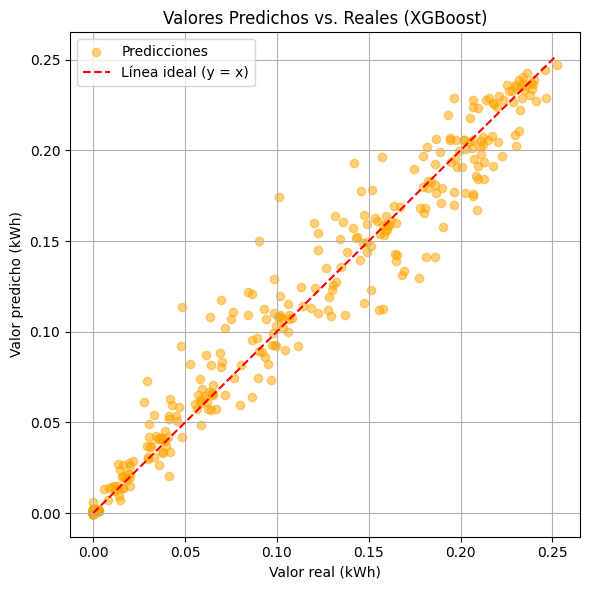

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Asegurar que los datos estén en formato 1D
y_test_array = np.array(y_test).ravel()
y_pred_array = np.array(y_pred).ravel()

# Gráfico de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_test_array, y_pred_array, color='orange', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_test_array)], [0, max(y_test_array)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
